# Motion Planning, Assignment 6: Motion Planning in a Frenet Frame

#### Thao Dang, Hochschule Esslingen

<a id="fig_1"></a>
![Fig. 1: Robot scenario](https://drive.google.com/uc?export=view&id=1v1RCijR0Jr678yk-UJZEnVA_PIr1MsDE)

In this assignment, you will use a state lattice planner to find a collision free path on while following a lane. Make sure you understand the description of the algorithm in the lecture slides or in Werling et al, “Optimal Trajectory Generation for Dynamic Street Scenarios in a Frenet Frame”, 2010, before you start coding. 

## Preparations

First, upload necessary files to Colab.

In [8]:
# Upload data - Colab ONLY!
# Select file: spline2d.py
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

Load the necessary libraries:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import spline2d
import copy
from matplotlib import animation, rc
from IPython.display import HTML

We first create a sample road scenario. The code for doing this is base on cubic splines. It is useful that you check out the underlying library, but it is not necessary for completing this excercise.

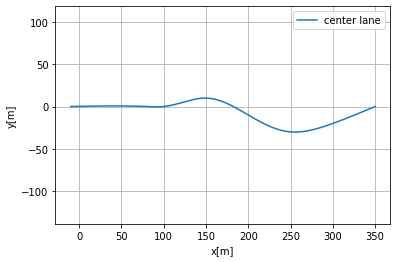

In [ ]:
def calc_road(offset=0):
    """Calculate a lane equally sampled in distance.
    
    To create a neighboring lane, as a simple approximation 
    just shift the lane in y by "offset".
    """
    ds = 0.1 # the distance (along the path) for sampling the road 
    # some road control points
    x_center = [-10, 80, 100, 150, 200, 250, 300, 350]
    y_center = [  0,  0,   0, 10, -10, -30, -20,   0]
    y_center = [y+offset for y in y_center]
    
    sp = spline2d.Spline2D(x_center, y_center)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))
    
    road = dict()
    road['x'] = rx
    road['y'] = ry
    road['yaw'] = ryaw
    road['curvature'] = rk
    road['s'] = s

    return road


center_lane = calc_road()
plt.plot(center_lane['x'], center_lane['y'], label='center lane')

#left_lane = calc_road(offset=4)
#plt.plot(left_lane['x'], left_lane['y'], label='left lane')

plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend();

## Exercise 1: Minimum jerk polynomials

You will start by writing a class implementing a quartic polynomial. Quartic polynomials  can connect a start configuration with an end configuration by a trajectory with minimum jerk.

As a starter, you are given a class that implements a quintic polynom. Study this class since it may be used as a template for your quartic polynomial.

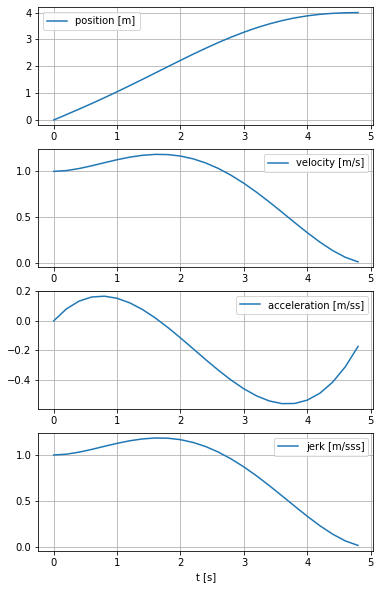

In [ ]:
class quintic_polynomial:
    """A quintic polynomial.
    The polynomial has the form a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5".
    """
    
    def __init__(self, xs, vxs, axs, xe, vxe, axe, T):
        """Initialize polynomial.
        
        Arguments:
            xs, vxs, axs: start point (pos [in m], vel [in m/s], acc [in m/ss])
            xe, vxe, axe: end point (pos [in m], vel [in m/s], acc [in m/ss])
            T: time when end point is reached [in s] 
        """
        # calc coefficient of quintic polynomial
        self.xs = xs
        self.vxs = vxs
        self.axs = axs
        self.xe = xe
        self.vxe = vxe
        self.axe = axe

        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2.0

        A = np.array([[T**3, T**4, T**5],
                      [3 * T ** 2, 4 * T ** 3, 5 * T ** 4],
                      [6 * T, 12 * T ** 2, 20 * T ** 3]])
        b = np.array([xe - self.a0 - self.a1 * T - self.a2 * T**2,
                      vxe - self.a1 - 2 * self.a2 * T,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]
        self.a5 = x[2]

    def calc_point(self, t):
        """Compute position [in m] at time t.
        """
        xt = self.a0 + self.a1 * t + self.a2 * t**2 + \
            self.a3 * t**3 + self.a4 * t**4 + self.a5 * t**5
        return xt

    def calc_first_derivative(self, t):
        """Compute velocity [in m/s] at time t.
        """
        xt = self.a1 + 2 * self.a2 * t + \
            3 * self.a3 * t**2 + 4 * self.a4 * t**3 + 5 * self.a5 * t**4
        return xt

    def calc_second_derivative(self, t):
        """Compute acceleration [in m/ss] at time t.
        """
        xt = 2 * self.a2 + 6 * self.a3 * t + 12 * self.a4 * t**2 + 20 * self.a5 * t**3
        return xt

    def calc_third_derivative(self, t):
        """Compute jerk [in m/sss] at time t.
        """
        xt = 6 * self.a3 + 24 * self.a4 * t + 60 * self.a5 * t**2
        return xt

    
qp = quintic_polynomial(0, 1, 0, 4, 0, 0, 5)
t = np.arange(0, 5, 0.2)
plt.figure(figsize=(6,10))
plt.subplot(4,1,1)
plt.plot(t, qp.calc_point(t), label='position [m]')
plt.legend()
plt.grid(True);

plt.subplot(4,1,2)
plt.plot(t, qp.calc_first_derivative(t), label='velocity [m/s]')
plt.legend()
plt.grid(True);

plt.subplot(4,1,3)
plt.plot(t, qp.calc_second_derivative(t), label='acceleration [m/ss]')
plt.legend()
plt.grid(True);

plt.subplot(4,1,4)
plt.plot(t, qp.calc_first_derivative(t), label='jerk [m/sss]')
plt.legend()
plt.grid(True);
plt.xlabel('t [s]');

del qp

Please fill in the missing code below. 

Note that a quartic polynomial is used when we are not interested in specifying an end position at time `T`. The boundary conditions for the starting point at time `t=0` of the polynomial are `(xs, vxs, axs)` (position, speed, and acceleration). For the end point, however, the boundary conditions at time `t=T` are only `(vxe, axe)` (speed and acceleration).

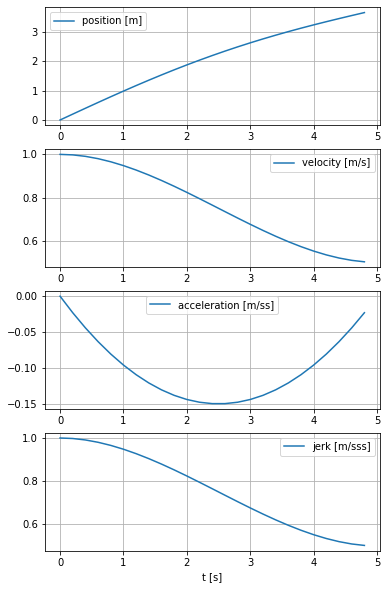

In [7]:
class quartic_polynomial:
    """A quartic polynomial.
    The polynomial has the form a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4".
    """
    
    def __init__(self, xs, vxs, axs, vxe, axe, T):
        """Initialize polynomial.
        
        Arguments:
            xs, vxs, axs: start point (pos [in m], vel [in m/s], acc [in m/ss])
            vxe, axe: end point (vel [in m/s], acc [in m/ss]), position is left free
            T: time when end point is reached [in s] 
        """
        # INSERT CODE HERE
        # calc coefficient of quartic polynomial
        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2
        A = np.array([[3 * T ** 2, 4 * T ** 3], [6 * T, 12 * T ** 2]])
        b = np.array([vxe - self.a1 - 2 * self.a2 * T,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)
        self.a3 = x[0]
        self.a4 = x[1]
        # END INSERTED CODE
        

    def calc_point(self, t):
        """Compute position [in m] at time t.
        """
        # INSERT CODE HERE        
        return self.a0 + self.a1*t + self.a2*t**2 + self.a3*t**3 + self.a4*t**4
        # END INSERTED CODE

    def calc_first_derivative(self, t):
        """Compute velocity [in m/s] at time t.
        """
        # INSERT CODE HERE     
        return self.a1 + 2*self.a2*t + 3*self.a3*t**2 + 4*self.a4*t**3
        # END INSERTED CODE

    def calc_second_derivative(self, t):
        """Compute acceleration [in m/ss] at time t.
        """
        # INSERT CODE HERE     
        return 2*self.a2 + 6*self.a3*t + 12*self.a4*t**2
        # END INSERTED CODE

    def calc_third_derivative(self, t):
        """Compute jerk [in m/sss] at time t.
        """
        # INSERT CODE HERE     
        return 6*self.a3 + 24*self.a4*t
        # END INSERTED CODE

    
qp = quartic_polynomial(0, 1, 0, 0.5, 0, 5)
t = np.arange(0, 5, 0.2)
plt.figure(figsize=(6,10))
plt.subplot(4,1,1)
plt.plot(t, qp.calc_point(t), label='position [m]')
plt.legend()
plt.grid(True);

plt.subplot(4,1,2)
plt.plot(t, qp.calc_first_derivative(t), label='velocity [m/s]')
plt.legend()
plt.grid(True);

plt.subplot(4,1,3)
plt.plot(t, qp.calc_second_derivative(t), label='acceleration [m/ss]')
plt.legend()
plt.grid(True);

plt.subplot(4,1,4)
plt.plot(t, qp.calc_first_derivative(t), label='jerk [m/sss]')
plt.legend()
plt.grid(True);
plt.xlabel('t [s]');

del qp

## Excercise 2: Combine x- and y-coordinates to form a trajectory

Using the quintic and quartic polynomials, you can generate a vehicle trajectory. In the example considered here, the vehicle is following a lane and avoids static obstacles. I such a scenario, we are not interested in where exactly along the arc-length of the lane the vehicle is but what speed it is travelling. Thus, it is suitable to choose a quartic polynomia in longitudinal direction `s` (in the Frenet frame) and a quintic polynomial in lateral direction `d`. More information on this method can be found in the lecture slides.

In the following, you will implement several routines of a class that generates and evaluates such trajectories. But first, we define some parameters that will be used later.

In [9]:
params = dict()
params['dT'] = 0.2 # sampling time [s]
params['target_speed'] = 30.0 / 3.6  # target speed [m/s]

# cost weights
params['KJ'] = 0.1
params['KT'] = 0.1
params['KD'] = 1.0
params['KLAT'] = 1.0
params['KLON'] = 1.0

# limits for drivable trajectory
params['max_speed'] = 55.0 / 3.6  # maximum speed [m/s]
params['max_accel'] = 6.0  # maximum acceleration [m/ss]
params['max_curvature'] = 0.1  # maximum curvature [1/m]

# for sampling trajectories
params['sample_road_width'] = 6 # maximum road width [m]
params['sample_road_width_step'] = 1 # # road width sampling step [m]
params['min_sample_T'] = 4 # min prediction time [s]
params['max_sample_T'] = 5 # max prediction time [s]
params['sample_T_step'] = 0.25 # prediction time sampling step [s]
params['min_sample_speed'] = 0 # min speed [m/s]
params['max_sample_speed'] = params['target_speed'] + 10/3.6 # max speed [m/s]
params['sample_speed_step'] = 10/3.6 # speed sampling step [s]

In [14]:
class FrenetTrajectory:
    """A class to generate a trajectory from a quartic and quintic polynomial.
    """

    def __init__(self):
        """ The constructor.
        """
        self.t = []
        
        # the longitudinal trajectory
        self.s = []
        self.ds_dt = []
        self.ds_dtt = []
        self.ds_dttt = []
        
        # the lateral trajectory
        self.d = []
        self.dd_dt = []
        self.dd_dtt = []
        self.dd_dttt = []

        # the trajectory costs
        self.cost_s = 0.0 # longitudinal
        self.cost_d = 0.0 # lateral
        self.cost = 0.0   # combined

        # the trajectory in global coords
        self.x = []
        self.y = []
        self.yaw = []
        self.ds = []
        self.c = []
        
        
    def calc_frenet_traj(self, s_start, dsdt_start, dsdt_end, \
                         d_start, dddt_start, dddtt_start, d_end, T):
        """Calculate a trajectory in the Frenet frame.
        
        The trajectory shall be formed of a quartic polynomial in longitudinal and a 
        quintic polynomial in lateral direction.
        The trajectory will be used to generate a conformal lattice. For such a 
        lattice structure, the desired end points at t=T has a simplified form:
        * The desired longitudonal acceleration at t=T is set to 0.
        * Both the desired lateral velocity and acceleration at t=T are set to 0.
        
        Arguments: 
            s_start, dsdt_start: the longitudinal position and velocity at time t=0
            dsdt_end: the longitudinal velocity at the end of the time horizon (t=T)
            d_start, dddt_start, dddtt_start: the lateral position, velocity 
                and acceleration at time t=0
            d_end: the lateral position at the end of the time horizon (t=T)
            T: the time horizon, i.e. the time when the end point shall be reached
            
        Output: The function will update several members of the class, namely:
            self.t: the time instances at which the trajectory is sampled 
                (sampling time params['dT'])
            self.s, self.ds_dt, self.ds_dtt, self.ds_dttt: the longitudinal 
                trajectory and its time derivatives sampled at self.t
            self.d, self.dd_dt, self.dd_dtt, self.dd_dttt: the lateral  
                trajectory and its time derivatives sampled at self.t
            self.cost_s, self.cost_d, self.cost: the costs (longitudinal,
                lateral, combined) for the trajectory. See lecture notes for 
                formula.
        """
                
        # INSERT CODE HERE
        # SEE DESCRIPTION AND TEST IN SEC EXERCISE 2.1
        self.t = np.arange(0, T, params['dT'])
        des_lat = quartic_polynomial(s_start, dsdt_start, 0, dsdt_end, 0, T)
        des_long = quintic_polynomial(d_start,dddt_start, dddtt_start, d_end,0,0, T)

        self.s = des_lat.calc_point(self.t)
        self.d = des_long.calc_point(self.t)
        self.ds_dt = des_lat.calc_first_derivative(self.t)
        self.dd_dt = des_long.calc_first_derivative(self.t)
        self.ds_dtt = des_lat.calc_second_derivative(self.t)
        self.dd_dtt = des_long.calc_second_derivative(self.t)
        self.ds_dttt = des_lat.calc_third_derivative(self.t)
        self.dd_dttt = des_long.calc_third_derivative(self.t)

        J_d = np.sum(self.dd_dttt**2)
        J_s = np.sum(self.ds_dttt**2)

        J_lat = params['KJ'] * J_d + params['KT'] * T + params['KD'] * (d_end-0)**2
        J_long = params['KJ'] * J_s + params['KT'] * T + params['KD'] * (dsdt_end-params['target_speed'])**2

        self.cost_d = J_lat * params['KLAT']
        self.cost_s = J_long * params['KLON']
        self.cost = J_lat + J_long 

        
        # END INSERTED CODE
        
        
    def frenet_to_global_coords(self, ref_curve):
        """ Transform the trajectory from Frenet coords to global coords 
            and compute derived values (arc-length, yaw, curvature).
            
        Arguments:
            ref_curve: the reference curve of the frenet frame as a dict with 
                elements 'x', 'y', 'yaw', 'curvature', 's'
        """
        
        # initialize
        self.x = []
        self.y = []
        self.yaw = []
        self.ds = []
        self.c = []
        
        # calc global positions
        for i in range(len(self.s)):
            si, di = self.s[i], self.d[i]
            if (si < min(ref_curve['s'])) or (si > max(ref_curve['s'])):
                break

            idx = spline2d.find_index(ref_curve['s'], si)
            ix, iy = ref_curve['x'][idx], ref_curve['y'][idx]
            iyaw = ref_curve['yaw'][idx] 
            
            # alternatively using numpy.interp:
            #ix = np.interp(si, ref_curve['s'], ref_curve['x'])
            #iy = np.interp(si, ref_curve['s'], ref_curve['y'])
            #iyaw = np.interp(si, ref_curve['s'], ref_curve['yaw'])

            fx = ix + di * np.cos(iyaw + np.pi / 2.0)
            fy = iy + di * np.sin(iyaw + np.pi / 2.0)
            self.x.append(fx)
            self.y.append(fy)

        # calc yaw and ds
        for i in range(len(self.x) - 1):
            dx = self.x[i + 1] - self.x[i]
            dy = self.y[i + 1] - self.y[i]
            self.yaw.append(np.arctan2(dy, dx))
            self.ds.append(np.sqrt(dx**2 + dy**2))

        self.yaw.append(self.yaw[-1])
        self.ds.append(self.ds[-1])

        # calc curvature
        for i in range(len(self.yaw) - 1):
            dsi = self.ds[i]
            if dsi==0:
                dsi = 1e-5
            self.c.append((self.yaw[i + 1] - self.yaw[i]) / dsi)
            

    def check_collisions(self, objs):
        """ Check if computed trajectory collides with any obj.
        
        Returns "True" if a collision has been detected, "False" otherwise.
        
        Arguments: 
            objs: the objects (type: [(x,y,r), ...])
        """
  
        for ox, oy, r in objs:
            d = [((ix - ox)**2 + (iy - oy)**2) for (ix, iy) in zip(self.x, self.y)]
            if any([di < r**2 for di in d]):
                return True

        return False


    def check_path_feasible(self, objs):
        """ Check if computed trajectory is feasible.
        
        A trajectory is feasible if it does not violate curvature constraints, 
        max speed limit, acceleration constraints and does not collide with any 
        obstacle. The limits for curvature, acceleration and speed can be found 
        in the "params" dict.
        
        Returns "True" if the trajectory is feasible, "False" otherwise.
        
        Arguments: 
            objs: the objects (type: [(x,y,r), ...])
        """
        
        # INSERT CODE HERE
        
        return not self.check_collisions(objs) and \
                all([abs(ci) < params['max_curvature'] for ci in self.c]) and \
                all([abs(di) < params['max_speed'] for di in self.dd_dt]) and \
                all([abs(di) < params['max_acceleration'] for di in self.dd_dtt]) and \
                all([abs(si) < params['max_speed'] for si in self.ds_dt]) and \
                all([abs(si) < params['max_acceleration'] for si in self.ds_dtt])
                
        # END INSERTED CODE
    

### Excercise 2.1: Calculate trajectory in Frenet frame

Implement the method ``calc_frenet_traj`` to compute a trajectory from given boundary conditions. Details on this function are given in the function header above.

Please note that the function should also compute the cost associated with the trajectory (cf. lecture slides). 

A test for the function is given below.

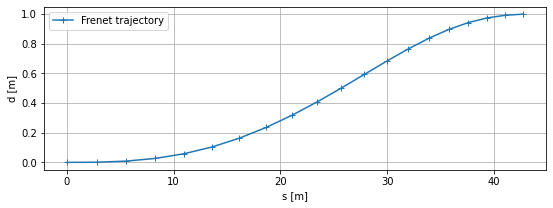

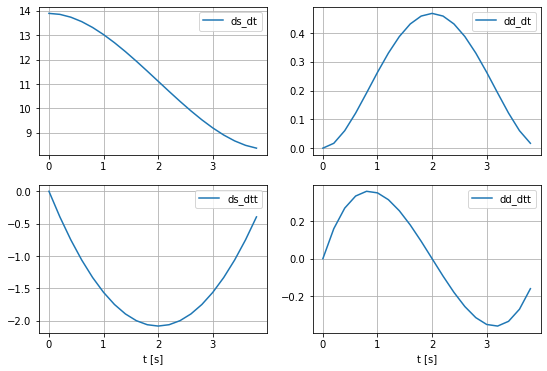

In [10]:
fp = FrenetTrajectory()

fp.calc_frenet_traj(0, 50/3.6, 30/3.6, 0, 0, 0, 1, 4)

plt.figure(figsize=(9,3))
plt.plot(fp.s, fp.d, '+-', label='Frenet trajectory')
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("d [m]")
plt.legend();

plt.figure(figsize=(9,6))

plt.subplot(2,2,1)
plt.plot(fp.t, fp.ds_dt, label='ds_dt')
plt.grid(True)
plt.legend();
plt.subplot(2,2,3)
plt.plot(fp.t, fp.ds_dtt, label='ds_dtt')
plt.grid(True)
plt.xlabel('t [s]')
plt.legend();

plt.subplot(2,2,2)
plt.plot(fp.t, fp.dd_dt, label='dd_dt')
plt.grid(True)
plt.legend();
plt.subplot(2,2,4)
plt.plot(fp.t, fp.dd_dtt, label='dd_dtt')
plt.grid(True)
plt.xlabel('t [s]')
plt.legend();

np.testing.assert_approx_equal(fp.cost, 5.0676, significant=3,
                               err_msg='unexpected cost value')
del fp

The following two cells demonstrate the usage of two functions that you will need later: `frenet_to_global_coords` and `check_collisions`. Check the function refernce to see what they are doing.

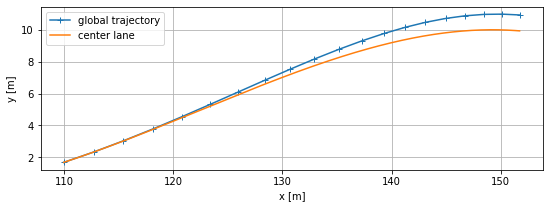

In [15]:
fp = FrenetTrajectory()

s0 = 120
fp.calc_frenet_traj(s0, 50/3.6, 30/3.6, 0, 0, 0, 1, 4)
fp.frenet_to_global_coords(center_lane)

plt.figure(figsize=(9,3))
plt.plot(fp.x, fp.y, '+-', label='global trajectory')

i0 = spline2d.find_index(center_lane['s'], fp.s[0])
i1 = spline2d.find_index(center_lane['s'], fp.s[-1])
plt.plot(center_lane['x'][i0:i1+1], center_lane['y'][i0:i1+1], label='center lane')

plt.grid(True)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend();

del fp

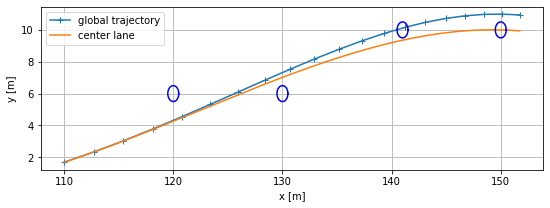

In [16]:
def plot_circle(x, y, size, color='-b'):  
    """Draw circle of radius size and center pos (x,y). 
    """
    deg = list(range(0, 360, 5))
    deg.append(0)
    xl = [x + size * np.cos(np.deg2rad(d)) for d in deg]
    yl = [y + size * np.sin(np.deg2rad(d)) for d in deg]
    plt.plot(xl, yl, color)
    
def plot_obstacles(obstacle_list):
    """Draw all obstacles in the scene.
    """
    for (ox, oy, size) in obstacle_list:
        plot_circle(ox, oy, size)

s0 = 120
obstacle_list = [
    (120, 6, 0.5),
    (130, 6, 0.5),
    (150, 10, 0.5),
    (141, 10, 0.5)
]  # [x, y, radius]

fp = FrenetTrajectory()
fp.calc_frenet_traj(s0, 50/3.6, 30/3.6, 0, 0, 0, 1, 4)
fp.frenet_to_global_coords(center_lane)

plt.figure(figsize=(9,3))
plt.plot(fp.x, fp.y, '+-', label='global trajectory')

i0 = spline2d.find_index(center_lane['s'], fp.s[0])
i1 = spline2d.find_index(center_lane['s'], fp.s[-1])
plt.plot(center_lane['x'][i0:i1+1], center_lane['y'][i0:i1+1], label='center lane')
plot_obstacles(obstacle_list)

plt.grid(True)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend();

assert fp.check_collisions(obstacle_list[:-1])==False, \
    'no collision with first three objects'

assert fp.check_collisions(obstacle_list)==True, \
    'collision with last object'

del fp

### Excercise 2.2: Verify if computed trajectory is feasible

Implement the method ``check_path_feasible`` to verify if the computed trajectory is feasibls (i.e. drivable and collision-free). Details on this function are given in the function header above.

Several tests for the function is given below.

KeyError: 'max_acceleration'

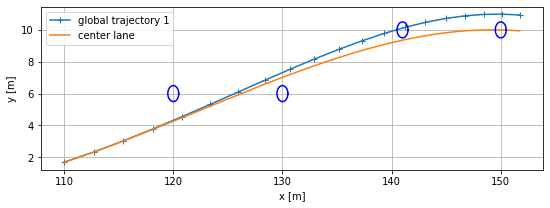

In [18]:
s0 = 120
obstacle_list = [
    (120, 6, 0.5),
    (130, 6, 0.5),
    (150, 10, 0.5),
    (141, 10, 0.5)
]  # [x, y, radius]

fp = FrenetTrajectory()
fp.calc_frenet_traj(s0, 50/3.6, 30/3.6, 0, 0, 0, 1, 4)
fp.frenet_to_global_coords(center_lane)

plt.figure(figsize=(9,3))
plt.plot(fp.x, fp.y, '+-', label='global trajectory 1')

i0 = spline2d.find_index(center_lane['s'], fp.s[0])
i1 = spline2d.find_index(center_lane['s'], fp.s[-1])
plt.plot(center_lane['x'][i0:i1+1], center_lane['y'][i0:i1+1], label='center lane')
plot_obstacles(obstacle_list)
plt.grid(True)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend();

assert fp.check_path_feasible(obstacle_list[:-1])==True, \
    'no collision with first three objects expected'

assert fp.check_path_feasible(obstacle_list)==False, \
    'collision with last object expected'

fp.calc_frenet_traj(s0, 50/3.6, 30/3.6, 0, 0, 0, -20, 2)
fp.frenet_to_global_coords(center_lane)
plt.plot(fp.x, fp.y, '+-', label='global trajectory 2')
plt.axis('equal')
plt.legend();

assert fp.check_path_feasible(obstacle_list)==False, \
    'curvature violation expected'

del fp

## Excercise 3: Finding the optimal trajectory 

Write a function `frenet_planning` as defined below that computes a state lattice of trajectories and finds the optimal feasible trajectory among all candidates. This function will be used to create a plot showing all feasible and invalid trajectories as shown at the top of this page.

All sampling parameters and weight constants required for this are defined in the `params`-dict. Remember that you should sample in three dimensions: lateral offset `d`, target speed `ds_dt` and target time `T`.

**Hint**: In this function, you may need to copy a object of type 'FrenetTrajectory'. To get such a copy, you may use `my_copy = copy.deepcopy(my_src)`.

In [ ]:
def frenet_planning(s0, v0, d0, dd0_dt, dd0_dtt, \
                    center_lane, obstacle_list, plot_trajs=True):
    """Compute a state lattice of trajectories and find the optimal trajectory.
    
    Arguments:
            s0, v0: the longitudinal position and velocity at time t=0
            d0, dd0_dt, dd0_dtt: the lateral position, velocity 
                and acceleration at time t=0
            center_lane: the reference curve of the frenet frame as a dict with 
                elements 'x', 'y', 'yaw', 'curvature', 's'
            obstacle_list: the circular obstacles (type: [(x,y,r), ...])
            plot_trajs: When "True" each computed trajectory shall be plotted. 
                Use green color when the trajectory is feasible and black color 
                otherwise.
                
    Returns:
            the optimal trajectory (type: FrenetTrajectory())
    """
    
    best_trajectory = None
    # INSERT CODE HERE
                        
    # END INSERTED CODE
                    
    return best_trajectory

In [ ]:
# initial state
s0 = 130 # current course position
v0 = 40/3.6 # current speed [m/s]
d0 = 0 # current lateral position [m]
dd0_dt = 0 # current lateral speed [m/s]
dd0_dtt = 0 # current latral acceleration [m/s]

obstacle_list = [
    (120, 6, 0.75),
    (130, 6, 0.75),
    (150, 10, 0.75)
]  # [x, y, radius]

i0 = spline2d.find_index(center_lane['s'], s0)
i1 = spline2d.find_index(center_lane['s'], s0+40)
plt.figure(figsize=(12,4))
plt.plot(center_lane['x'][i0:i1+1], center_lane['y'][i0:i1+1], label='center lane')

best_trajectory = frenet_planning(s0, v0, d0, dd0_dt, dd0_dtt, 
                                  center_lane, obstacle_list)
    
plt.plot(best_trajectory.x, best_trajectory.y, 'r', linewidth=3)
plot_obstacles(obstacle_list)
plt.grid(True)
plt.axis('equal')
plt.xlabel("x [m]")
plt.ylabel("y [m]");

print('Best trajectory: s_end=%.1f, v_end=%.1f, d_end=%.1f' % \
      (best_trajectory.s[-1], 3.6*best_trajectory.ds_dt[-1], best_trajectory.d[-1]))
                

## Putting it all together 

When you have completed all code above, it's now time for a nice video and testing your code in a closed loop scenario. There's nothing to implement here. Just checkout what the `animate` function is doing and make sure your vehicle does not collide with any obstacle. 

In [ ]:
# initial state
s0 = 20 # current course position
v0 = 40/3.6 # current speed [m/s]
d0 = 1 # current lateral position [m]
dd0_dt = 0 # current lateral speed [m/s]
dd0_dtt = 0 # current latral acceleration [m/s]

obstacle_list = [
    (120, 6,   1.5),
    (130, 6,   1.5),
    (150, 10,  0.5), 
    (190, -10, 1.5),
    (200, -10, 1.5),
    (250, -30, 1.5)
]  # [x, y, radius]

num_loops = 150                
    
# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots(figsize=(11,8))
plt.close()
ax.grid(True)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
course, = ax.plot([], [], "g", label="center_lane")
objects, = ax.plot([], [], "kx", markersize=14, label="objects")
trajectory, = ax.plot([], [], "ro-", label="trajectory")
title_text = ax.text(.8, .9, '', transform = ax.transAxes)
vehicle, = ax.plot([], [], "b", label="vehicle")


def getVehicleContours(pos_x, pos_y, yaw):
    """Compute object contours."""

    veh_dim_x, veh_dim_y = 4, 1.9  # [m] size of vehicle (length, width)
    L_2, W_2 = veh_dim_x/2.0, veh_dim_y/2.0
    u = np.array([
        [0, -W_2, 1],    # 1
        [L_2, -W_2, 1],  # 2
        [L_2, W_2, 1],   # 3
        [0, W_2, 1],     # 4
        [L_2, 0, 1],     # 5
        [0, -W_2, 1],    # 6
        [0, W_2, 1],     # 7
        [-L_2, W_2, 1],  # 8
        [-L_2, -W_2, 1],  # 9
        [0, -W_2, 1]     # 10
    ]).T

    T = np.array([
        [np.cos(yaw), -np.sin(yaw), pos_x],
        [np.sin(yaw), np.cos(yaw), pos_y]
    ])

    v = np.dot(T, u)
    return v[0, :], v[1, :]

# initialization function: plot the background of each frame
def init():
    course.set_data(center_lane['x'], center_lane['y']) 
    xo, yo, _ = zip(*obstacle_list)
    objects.set_data(xo, yo) 
    return (course, objects, )
  
# animation function: this is called sequentially
def animate(i):
    global s0, v0, d0, dd0_dt, dd0_dtt
    fp = frenet_planning(s0, v0, d0, dd0_dt, dd0_dtt, 
                         center_lane, obstacle_list, plot_trajs=False)
    
    assert fp is not None, 'Could not find solution in step %d.' % i

    s0 = fp.s[1]
    v0 = fp.ds_dt[1]
    d0 = fp.d[1]
    dd0_dt = fp.dd_dt[1]
    dd0_dtt = fp.dd_dtt[1]

    if s0 > center_lane['s'][-1] - params['target_speed']*params['max_sample_T']:
        assert False, 'Reached end of reference path (step %d).' % i
        
    trajectory.set_data(fp.x, fp.y)
    title_text.set_text(("Speed: %.1f km/h" % (fp.ds_dt[-1] * 3.6)))
    px, py = getVehicleContours(fp.x[0], fp.y[0], fp.yaw[0])
    vehicle.set_data(px, py)
    
    fig.gca().set(xlim=(fp.x[0]-5, fp.x[0]+45), ylim=(fp.y[0]-10, fp.y[0]+10))
    return (trajectory, title_text, vehicle, )

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=num_loops, 
                               interval=100, blit=True)

rc('animation', html='jshtml')
anim